In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, root_mean_squared_error, r2_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


## Ví dụ 1:

Loading IRIS dataset:

In [2]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 
  
df = pd.DataFrame(X)
label_map = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
df['variety'] = y['class'].map(label_map)
df['variety_name'] = y['class']
df.head()

,sepal length,sepal width,petal length,petal width,variety,variety_name
0,5.1,3.5,1.4,0.2,0,Iris-setosa
1,4.9,3.0,1.4,0.2,0,Iris-setosa
2,4.7,3.2,1.3,0.2,0,Iris-setosa
3,4.6,3.1,1.5,0.2,0,Iris-setosa
4,5.0,3.6,1.4,0.2,0,Iris-setosa


Visualize:

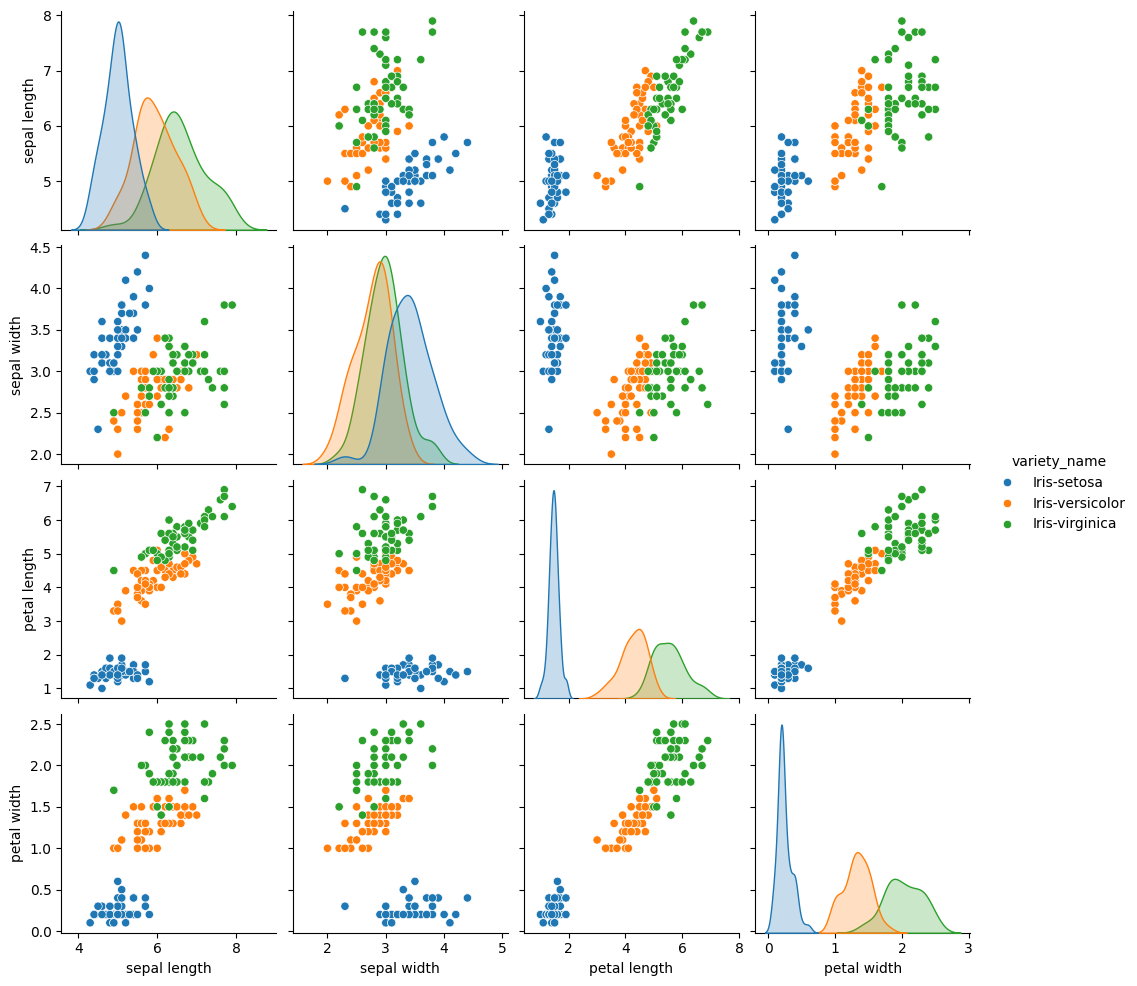

In [189]:
sns.pairplot(df.drop('variety', axis=1), hue='variety_name')

Text(0.5, 1.0, 'Correlation matrix')

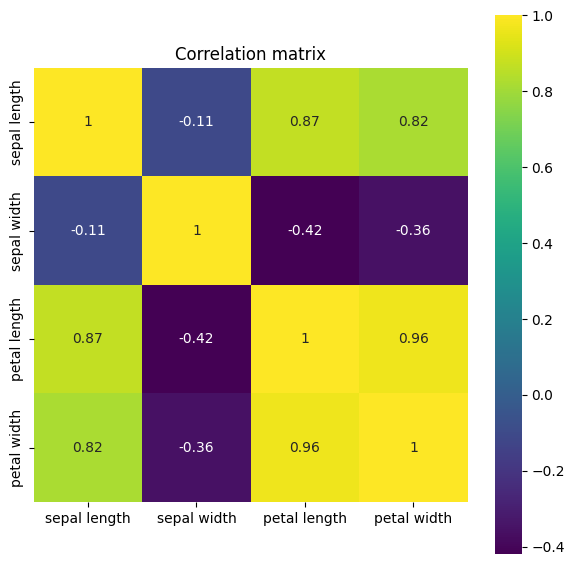

In [3]:
species = df["variety"].tolist()
X = df.drop(["variety", 'variety_name'], axis=1)
# Standardize the data
X = (X - X.mean()) / X.std(ddof=0)
# Calculating the correlation matrix of the data
X_corr = (1 / 150) * X.T.dot(X)
# Plotting the correlation matrix
plt.figure(figsize=(7, 7))
sns.heatmap(X_corr, vmax=1, square=True,annot=True, cmap='viridis')
plt.title('Correlation matrix')

### Bài tập tự thực hành:

##### 1. Giảm chiều dữ liệu còn 2 chiều và trực quan hoá:

In [219]:
## using method 1 'cause method 2 does not sort eigen values in descending order
u, s, v = np.linalg.svd(X_corr)
eig_values, eig_vectors = s, u

Text(0.5, 0, 'Dimensions')

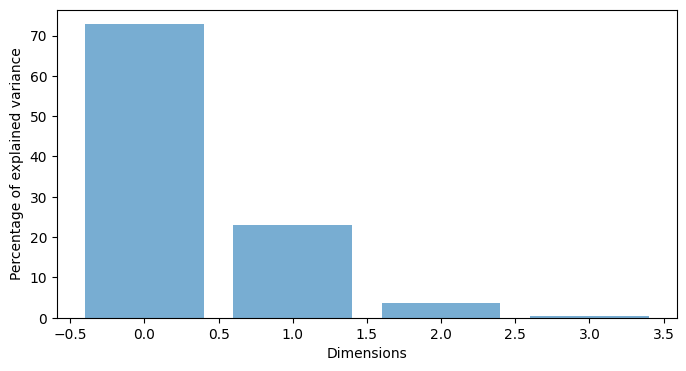

In [220]:
explained_variance=(eig_values / np.sum(eig_values)) * 100 
plt.figure(figsize=(8,4)) 
plt.bar(range(4), explained_variance, alpha=0.6) 
plt.ylabel('Percentage of explained variance') 
plt.xlabel('Dimensions')

In [221]:
pc1 = X.dot(eig_vectors[:,0]) 
pc2 = X.dot(eig_vectors[:,1])

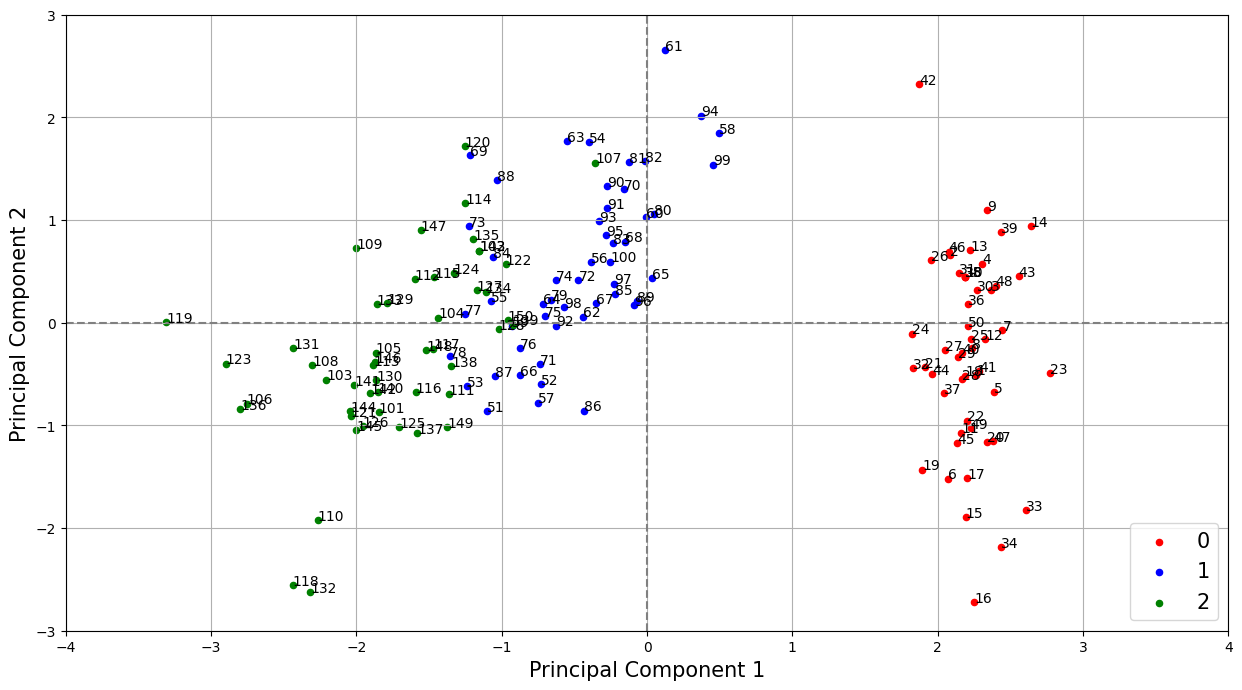

In [223]:
def plot_scatter(pc1, pc2): 
    fig, ax = plt.subplots(figsize=(15, 8)) 
     
    species_unique = list(set(species)) 
    species_colors = ["r","b","g"] 
     
    for i, spec in enumerate(species): 
        plt.scatter(pc1[i], pc2[i], label = spec, s = 20, c=species_colors[species_unique.index(spec)]) 
        ax.annotate(str(i+1), (pc1[i],pc2[i])) 
     
    from collections import OrderedDict 
    handles, labels = plt.gca().get_legend_handles_labels() 
    by_label = OrderedDict(zip(labels, handles)) 
    plt.legend(by_label.values(), by_label.keys(), prop={'size': 15}, loc=4) 
     
    ax.set_xlabel('Principal Component 1', fontsize = 15) 
    ax.set_ylabel('Principal Component 2', fontsize = 15) 
    ax.axhline(y=0, color="grey", linestyle="--") 
    ax.axvline(x=0, color="grey", linestyle="--") 
     
    plt.grid() 
    plt.axis([-4, 4, -3, 3]) 
    plt.show() 
     
plot_scatter(pc1, pc2)

##### 2. Huấn luyện mô hình

a. Trước khi giảm chiều

In [224]:
# train test split
X = df.drop(['variety', 'variety_name'], axis=1)
y = df['variety']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

Text(0.5, 1.0, 'Accuracy: 0.9666666666666667')

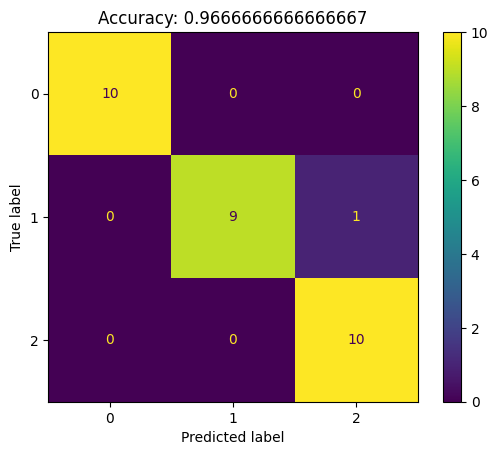

In [225]:
# fitting model
log_reg = LogisticRegression(fit_intercept=True, max_iter=10000)
log_reg.fit(X_train, y_train)

# predict
y_pred = log_reg.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Accuracy: {accuracy_score(y_test, y_pred)}')

b. Sau khi giảm chiều

Text(0, 0.5, 'Explained std(%)')

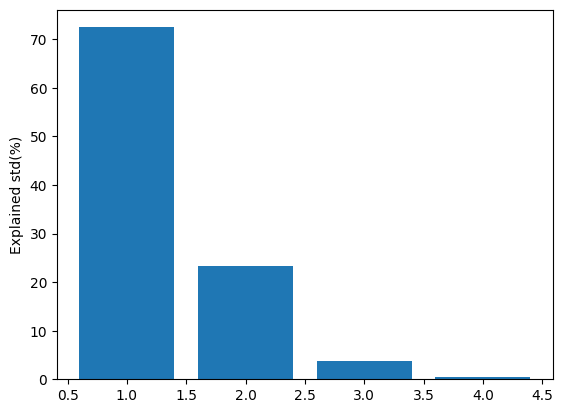

In [226]:
# (i) train test split -> pca

## normalize data
train_mean = X_train.mean()
train_std = X_train.std(ddof=0)
X_train_normalized = (X_train - train_mean) / train_std
X_test_normalized = (X_test - train_mean) / train_std
X_train_corr = 1 / 150 * X_train_normalized.T.dot(X_train_normalized)

## eigen values/vectors
u, s, v = np.linalg.svd(X_train_corr)
eigen_values, eigen_vectors = s, u

## explained std instead of explained variance 'cause we're working with correlation matrix
eigen_values, eigen_vectors = results.eigenvalues, results.eigenvectors
explained_std = eigen_values / np.sum(eigen_values) * 100
plt.bar(range(1, 5) ,explained_std)
plt.ylabel('Explained std(%)')

In [232]:
## transformation on normalized data
## the first two components contain > 90% of informations
pca_train = X_train_normalized.dot(eigen_vectors).iloc[:, :2]
pca_test = X_test_normalized.dot(eigen_vectors).iloc[:, :2]

Text(0.5, 1.0, 'Accuracy: 0.9')

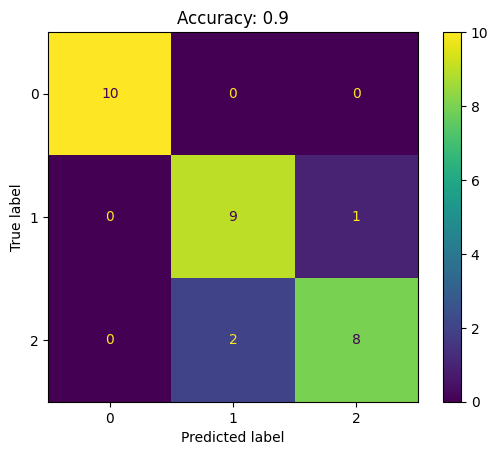

In [235]:
# fitting model
log_reg = LogisticRegression(fit_intercept=True, max_iter=10000)
log_reg.fit(pca_train, y_train)

# predict
y_pred = log_reg.predict(pca_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Text(0, 0.5, 'Explained std(%)')

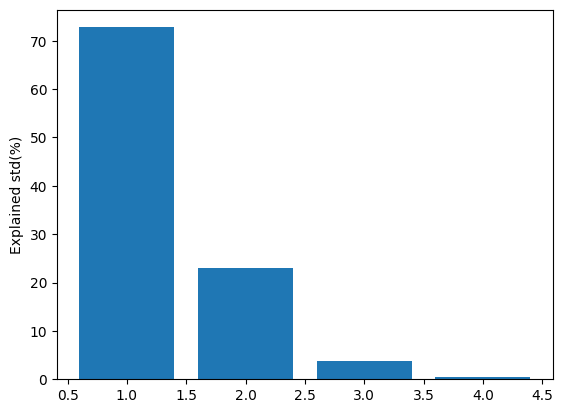

In [236]:
# (ii) pca on whole dataset -> train test split
X = df.drop(['variety', 'variety_name'], axis=1)
y = df['variety']

X_normalized = (X - X.mean()) / X.std(ddof=0)
X_corr = 1 / 150 * X_normalized.T.dot(X_normalized)

## eigen values, eigen vectors
u, s, v = np.linalg.svd(X_corr)
eigen_values, eigen_vectors = s, u

explained_std = eigen_values / np.sum(eigen_values) * 100

plt.bar(range(1, 5), explained_std)
plt.ylabel('Explained std(%)')

In [239]:
## transform on normalized data
pca = X_normalized.dot(eigen_vectors).iloc[:, :2]

Text(0.5, 1.0, 'Accuracy: 0.9')

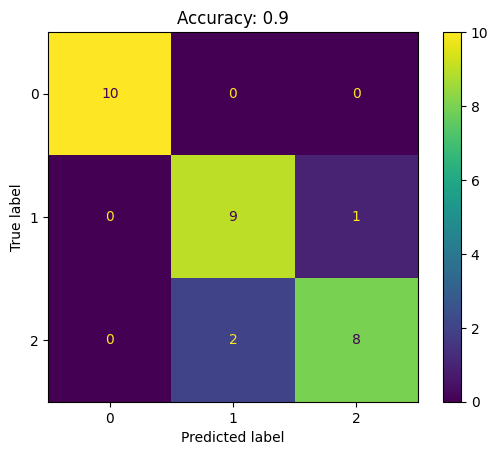

In [240]:
## train test split
pca_train, pca_test, y_train, y_test = train_test_split(pca, y, random_state=42, test_size=0.2, stratify=y)

log_reg = LogisticRegression(fit_intercept=True, max_iter=10000)
log_reg.fit(pca_train, y_train)

## predict
y_pred = log_reg.predict(pca_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Kết quả trong trường hợp (ii) không khác biệt so với (i). Tuy nhiên khi thực hiện PCA trên toàn bộ dữ liệu rồi mới chia train test, ta đã đưa cả thông tin của dữ liệu test vào để huấn luyện mô hình, điều này phản ánh không đúng các bài toán trong thực tế. Do đó, quy trình phù hợp sẽ là:
- Chia train test
- Thực hiện thống kê và giảm chiều trên tập train -> huấn luyện mô hình
- Biến đổi dữ liệu trên tập test bằng phép biến đổi tìm được trên tập train
- Đưa ra dự đoán và đánh giá mô hình

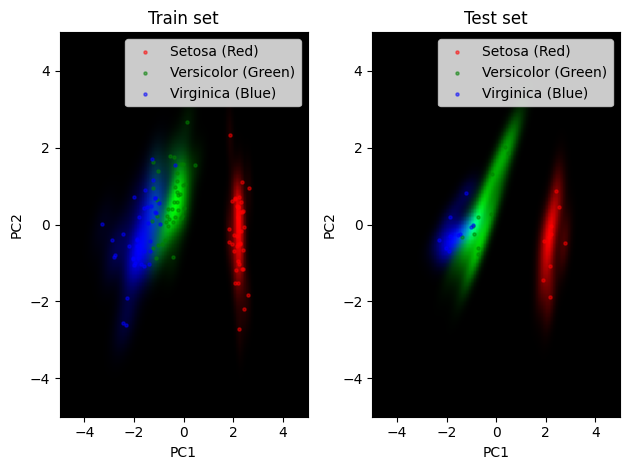

In [ ]:
# Đồ thị nhờ ChatGPT gen
# distribution after pca
from scipy.stats import gaussian_kde

# Tạo dữ liệu ngẫu nhiên cho 3 lớp
def display(X, label, is_train=True):
    X0_idx = label == 0
    X1_idx = label == 1
    X2_idx = label == 2

    x0, y0 = X[X0_idx][0], X[X0_idx][1]
    x1, y1 = X[X1_idx][0], X[X1_idx][1]
    x2, y2 = X[X2_idx][0], X[X2_idx][1]

    # Tạo lưới 2D
    grid_size = 100
    x_grid = np.linspace(-5, 5, grid_size)
    y_grid = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Hàm tính mật độ KDE cho từng lớp
    def compute_kde(x, y, X, Y):
        xy = np.vstack([x, y])
        kde = gaussian_kde(xy)
        Z = np.reshape(kde(np.vstack([X.ravel(), Y.ravel()])), X.shape)
        return Z / Z.max()  # Chuẩn hóa về [0,1] để dễ vẽ màu

    # Tính mật độ cho từng lớp
    Z1 = compute_kde(x0, y0, X, Y)  # Lớp đỏ
    Z2 = compute_kde(x1, y1, X, Y)  # Lớp xanh lá
    Z3 = compute_kde(x2, y2, X, Y)  # Lớp xanh dương

    # Tạo ảnh RGB từ 3 lớp mật độ
    rgb_image = np.dstack([Z1, Z2, Z3])

    # Vẽ biểu đồ
    plt.imshow(rgb_image, extent=[-5, 5, -5, 5], origin='lower', aspect='auto')

    # Vẽ scatter plot để hiển thị dữ liệu gốc
    plt.scatter(x0, y0, color="red", s=5, alpha=0.5, label="Setosa (Red)")
    plt.scatter(x1, y1, color="green", s=5, alpha=0.5, label="Versicolor (Green)")
    plt.scatter(x2, y2, color="blue", s=5, alpha=0.5, label="Virginica (Blue)")
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.legend()
    if is_train:
        plt.title('Train set')
    else:
        plt.title('Test set')

plt.subplot(1,2,1)
display(pca_train, y_train, is_train=True)
plt.subplot(1,2,2)
display(pca_test, y_test, is_train=False)
plt.tight_layout()
plt.show()

So sánh kết quả trước và sau khi giảm chiều: 
- Kết quả của mô hình trên dữ liệu nguyên gốc tốt hơn so với trên dữ liệu đã giảm chiều
- Nguyên nhân là do sau khi giảm chiều xuống còn 2, mặc dù lượng thông tin mất đi là không đáng kể (< 10%) nhưng dữ liệu trong không gian mới có sự chồng lấn về phân phối giữa class versicolor và virginica (được minh hoạ trong hình trên), điều này dẫn tới một vài kết quả phân loại sai  giữa 2 lớp này (có thể thấy thông qua confusion matrix)

## Ví dụ 2

Loading data:

In [ ]:
from sklearn.preprocessing import StandardScaler 
import warnings 
warnings.filterwarnings('ignore') 
 
df= pd.read_csv('pd_speech_features.csv') 
df['class'].value_counts()

class
1    564
0    192
Name: count, dtype: int64

In [130]:
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


In [247]:
X, y = df.iloc[:, 1:-1], df.iloc[:, -1]

#### 1.

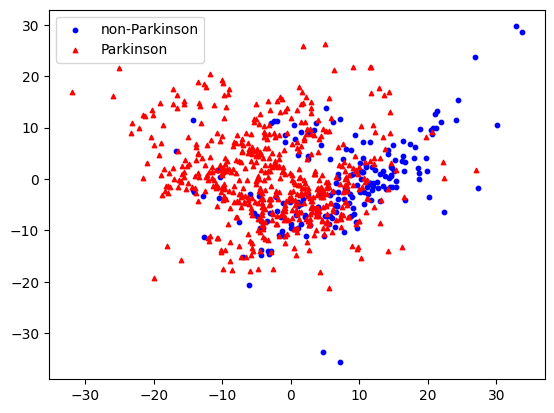

In [255]:
X_normalized = (X - X.mean()) / X.std(ddof=0)
X_corr = 1 / 756 * X_normalized.T.dot(X_normalized)

# eigen values & vectors
u,s,v = np.linalg.svd(X_corr) 
eigen_values, eigen_vectors = s, u

pca = X_normalized.dot(eigen_vectors).iloc[:, :2]

pca_0 = pca[y == 0]
pca_1 = pca[y == 1]

plt.scatter(pca_0.iloc[:, 0], pca_0.iloc[:, 1], label='non-Parkinson', c='blue', s=10)
plt.scatter(pca_1.iloc[:, 0], pca_1.iloc[:, 1], label='Parkinson', c='red', marker='^', s=10)
plt.legend()
plt.show()

#### 2.

Text(0.5, 1.0, 'Accuracy: 0.8046875')

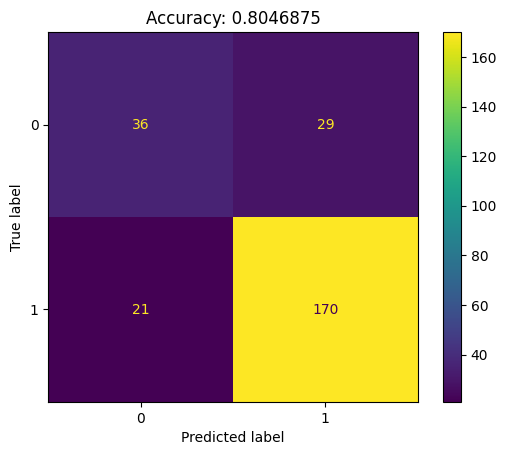

In [257]:
pca = X_normalized.dot(eigen_vectors).iloc[:, :200]

pca_train, pca_test, y_train, y_test = train_test_split(pca, y, random_state=42, train_size=500, stratify=y)

# fitting model
log_reg = LogisticRegression(fit_intercept=True, max_iter=10000)
log_reg.fit(pca_train, y_train)

# predict
y_pred = log_reg.predict(pca_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Accuracy: {accuracy_score(y_test, y_pred)}')

#### 3.

Text(0.5, 1.0, 'Accuracy: 0.82421875')

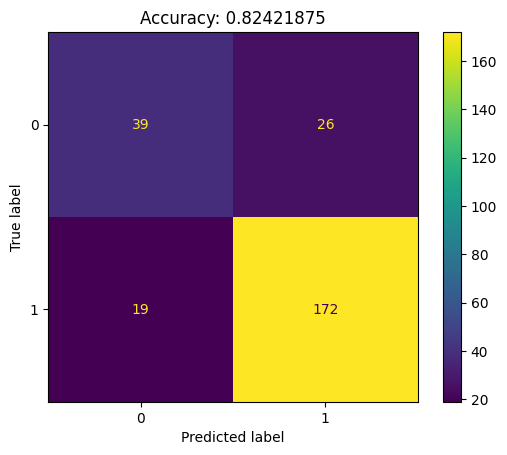

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=500, random_state=42, stratify=y)

# normalize
train_mean = X_train.mean()
train_std = X_train.std(ddof=0)

X_train_normalized = (X_train - train_mean) / train_std
X_test_normalized = (X_test - train_mean) / train_std

# pca
X_train_corr = 1 / 500 * X_train_normalized.T.dot(X_train_normalized)

## method 2
# result = np.linalg.eig(X_train_corr)
# eigen_values, eigen_vectors = result.eigenvalues, result.eigenvectors

# using method 1 instead of method 2 to avoid exception of casting from complex to real number
u,s,v = np.linalg.svd(X_train_corr) 
eigen_values, eigen_vectors = s, u

pca_train = X_train_normalized.dot(eigen_vectors).iloc[:, :200]
pca_test = X_test_normalized.dot(eigen_vectors).iloc[:, :200]

# fitting model
log_reg = LogisticRegression(fit_intercept=True, max_iter=10000)
log_reg.fit(pca_train, y_train)

# predict
y_pred = log_reg.predict(pca_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Accuracy: {accuracy_score(y_test, y_pred)}')

- Kết quả của 2 trường hợp không quá khác biệt, điều này có thể lý giải bởi phân phối trên 2 tập train và test không quá khác biệt.

#### 4.

Text(0.5, 1.0, '51 principle components have explained_std=80.02784982685462')

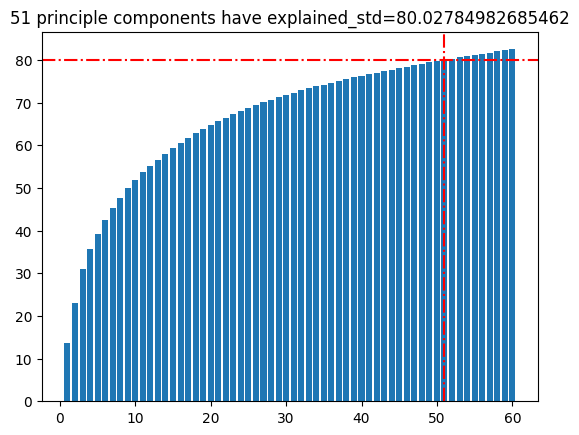

In [286]:
# train test split -> pca
explained_std = eigen_values / np.sum(eigen_values) * 100
cummulative_explained_std = np.cumsum(explained_std)

plt.bar(range(1, 61), cummulative_explained_std[:60])
plt.axhline(y=80, c='r', linestyle='dashdot')
plt.axvline(x=51, c='r', linestyle='dashdot')
plt.title(f'51 principle components have explained_std={cummulative_explained_std[50]}')

Text(0.5, 1.0, 'Accuracy: 0.82421875')

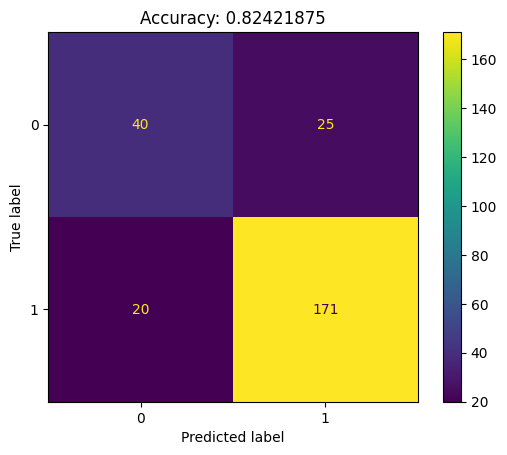

In [287]:
pca_train = X_train_normalized.dot(eigen_vectors).iloc[:, :51]
pca_test = X_test_normalized.dot(eigen_vectors).iloc[:, :51]

# fitting model
log_reg = LogisticRegression(fit_intercept=True, max_iter=10000)
log_reg.fit(pca_train, y_train)

# predict
y_pred = log_reg.predict(pca_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f'Accuracy: {accuracy_score(y_test, y_pred)}')

- Chỉ với 51 chiều (giữ lại khoảng 80% thông tin), mô hình của ta có thể cho ta độ chính xác tương đương với việc sử dụng 200 chiều

#### 5.

Without PCA:

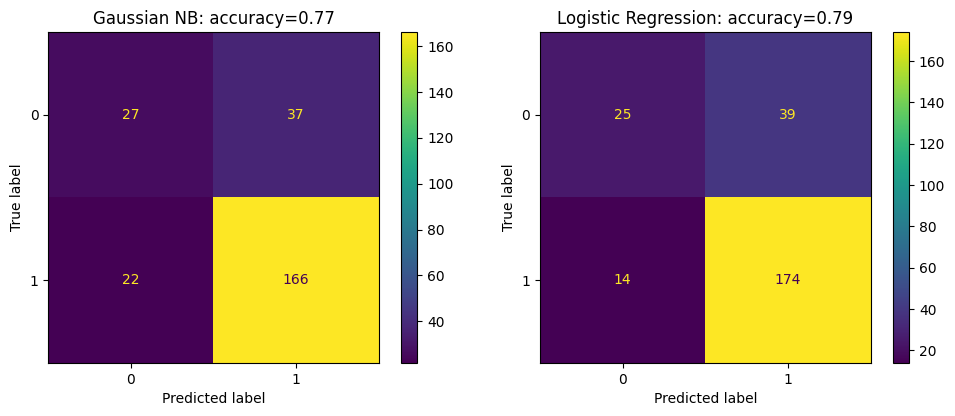

In [315]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42, stratify=y)

# Gaussian Naive Bayes
gaussian_nb = GaussianNB(priors=None)
gaussian_nb.fit(X_train, y_train)

### predict
gnb_pred = gaussian_nb.predict(X_test)

# Logistic regression
log_reg = LogisticRegression(fit_intercept=True, max_iter=10000)
log_reg.fit(X_train, y_train)

### predict
lr_pred = log_reg.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Tạo 2 subplot

# Vẽ confusion matrix cho Gaussian Naive Bayes trên ax[0]
ConfusionMatrixDisplay.from_predictions(y_test, gnb_pred, ax=axes[0])
axes[0].set_title(f'Gaussian NB: accuracy={accuracy_score(y_test, gnb_pred):.2f}')

# Vẽ confusion matrix cho Logistic Regression trên ax[1]
ConfusionMatrixDisplay.from_predictions(y_test, lr_pred, ax=axes[1])
axes[1].set_title(f'Logistic Regression: accuracy={accuracy_score(y_test, lr_pred):.2f}')

plt.tight_layout()  # Đảm bảo bố cục đẹp
plt.savefig(f'vd2_without_pca.jpg')
plt.show()

With PCA:

Text(0.5, 1.0, '52 principle components have explained_std=80.24%')

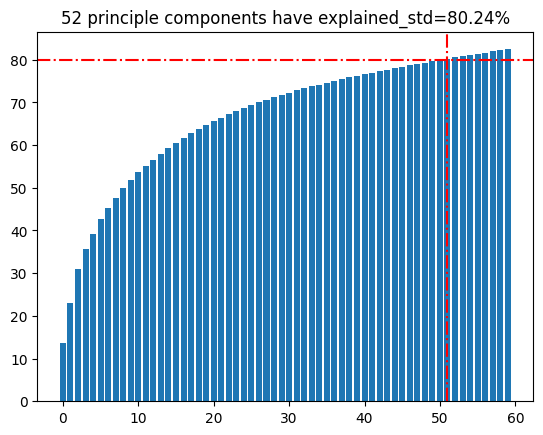

In [313]:
# data normalization
train_mean = X_train.mean()
train_std = X_train.std(ddof=0)

X_train_normalized = (X_train - train_mean) / train_std
X_test_normalized = (X_test - train_mean) / train_std

# pca
X_train_corr = 1 / len(X_train) * X_train_normalized.T.dot(X_train_normalized)
u, s, v = np.linalg.svd(X_train_corr)
eigen_values, eigen_vectors = s, u

# explained std
explained_std = eigen_values / np.sum(eigen_values) * 100
cummulative_explained_std = np.cumsum(explained_std)

plt.bar(range(60), cummulative_explained_std[:60])
plt.axhline(y=80, c='r', linestyle='dashdot')
plt.axvline(x=51, c='r', linestyle='dashdot')
plt.title(f'52 principle components have explained_std={cummulative_explained_std[51]:.2f}%')

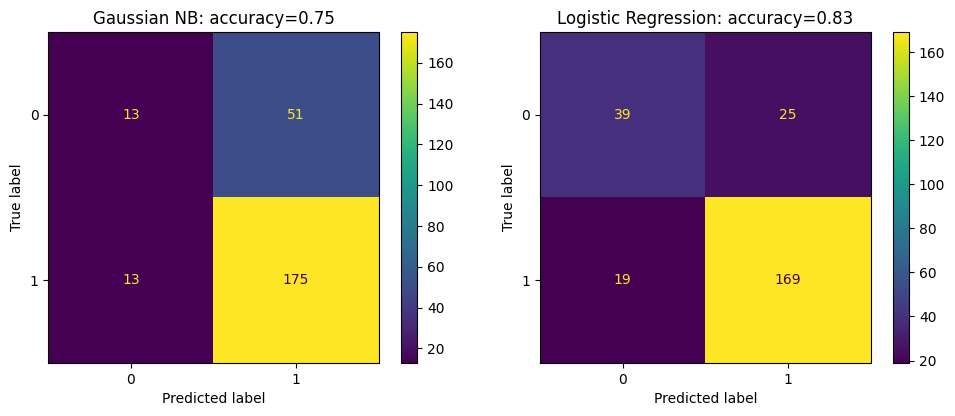

In [316]:
pca_train = X_train_normalized.dot(eigen_vectors).iloc[:, :52]
pca_test = X_test_normalized.dot(eigen_vectors).iloc[:, :52]

# Gaussian NB
gaussian_nb = GaussianNB(priors=None)
gaussian_nb.fit(pca_train, y_train)

## predict
gnb_pred = gaussian_nb.predict(pca_test)

# Logistic regression
log_reg = LogisticRegression(fit_intercept=True, max_iter=10000)
log_reg.fit(pca_train, y_train)

## predict
lr_pred = log_reg.predict(pca_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Tạo 2 subplot

# Vẽ confusion matrix cho Gaussian Naive Bayes trên ax[0]
ConfusionMatrixDisplay.from_predictions(y_test, gnb_pred, ax=axes[0])
axes[0].set_title(f'Gaussian NB: accuracy={accuracy_score(y_test, gnb_pred):.2f}')

# Vẽ confusion matrix cho Logistic Regression trên ax[1]
ConfusionMatrixDisplay.from_predictions(y_test, lr_pred, ax=axes[1])
axes[1].set_title(f'Logistic Regression: accuracy={accuracy_score(y_test, lr_pred):.2f}')

plt.tight_layout()  # Đảm bảo bố cục đẹp
plt.savefig(f'vd2_with_pca.jpg')
plt.show()

Phương pháp Gaussian Naive Bayes cho kết quả thay đổi nhiều hơn, rõ nhất là ở nhãn dự đoán 0. Điều này có thể giải thích do:
- Gaussian NB tính toán dựa trên giả thuyết về tính độc lập giữa các thành phần, việc chuyển cơ sở của dữ liệu cho ta một tập features mới với các thành phần độc lập với nhau dẫn đến thay đổi kết quả mô hình.
- Việc chuyển cơ sở cũng làm thay đổi phần phối của dữ liệu (chủ yếu là ở phương sai, khi nó khiến cho một số thành phần mang phương sai lớn hơn hẳn các thành phần còn lại), mà Gaussian NB lại tính toán kết quả đầu ra bằng cách dựa trực tiếp vào giá trị p(X | k) nên kết quả sẽ bị ảnh hưởng nhiều.

## Ví dụ 3.

In [441]:
X = []
y = []

# read data
with open('vidu4_lin_reg.txt', 'r') as f:
    lines = f.readlines()
    header = lines[0].strip()
    attributes = header.split(' ')
    
    for line in lines[1:]:
        values = line.strip().split(' ')
        values = list(map(float, values))
        X.append(values[1:-1])
        y.append(values[-1])
X = np.array(X)
y = np.array(y)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

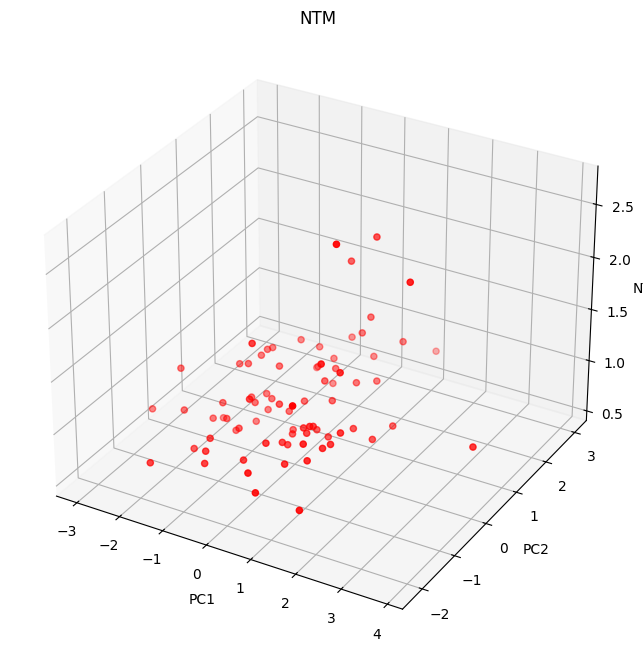

In [459]:
# pca
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
pca_train = pca.fit_transform(X_train_scaled)
pca_test = pca.transform(X_test_scaled)

# visualize
# Tạo figure và trục 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter dữ liệu gốc
ax.view_init(elev=20, azim=60)  # Góc nhìn từ trên 30 độ, xoay ngang 60 độ
ax = fig.add_subplot(111, projection='3d')

# Vẽ scatter plot
ax.scatter(pca_train[:, 0], pca_train[:, 1], y_train, c='r', marker='o')

# Gán nhãn trục
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('NTM')
ax.set_title('NTM')

plt.show()

Without PCA:

In [453]:
# Fitting model
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train, y_train)

# Predict trên train & test
y_train_pred = lin_reg.predict(X_train)
y_test_pred = lin_reg.predict(X_test)

print(f'Train RMSE: {root_mean_squared_error(y_train, y_train_pred)}')
print(f'Train R2: {r2_score(y_train, y_train_pred)}')
print(f'Test RMSE: {root_mean_squared_error(y_test, y_test_pred)}')
print(f'Test R2: {r2_score(y_test, y_test_pred)}')

Train RMSE: 0.3419589256394284
Train R2: 0.17106553569775407
Test RMSE: 0.42251003643660534
Test R2: 0.23209149234182402


Using PCA:

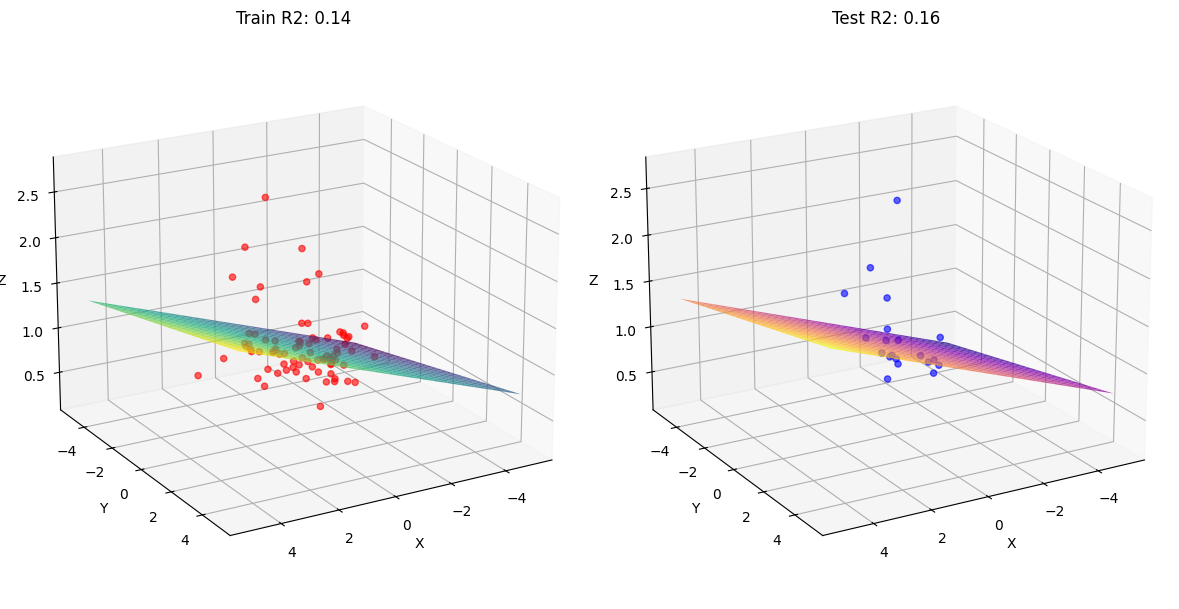

In [454]:
# Fitting model
lin_reg = LinearRegression()
lin_reg.fit(pca_train, y_train)

# Predict trên train & test
y_train_pred = lin_reg.predict(pca_train)
y_test_pred = lin_reg.predict(pca_test)

# Tạo lưới điểm (X, Y) để vẽ mặt phẳng hồi quy
X_grid, Y_grid = np.meshgrid(np.linspace(-5, 5, 20), np.linspace(-5, 5, 20))
Z_pred = lin_reg.intercept_ + lin_reg.coef_[0] * X_grid + lin_reg.coef_[1] * Y_grid  # Mặt phẳng hồi quy

# Tạo figure và 2 subplot 3D
fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

# Vẽ trên tập TRAIN
axes[0].view_init(elev=20, azim=60)
axes[0].scatter(pca_train[:, 0], pca_train[:, 1], y_train, c='r', marker='o', alpha=0.6)
axes[0].plot_surface(X_grid, Y_grid, Z_pred, cmap='viridis', alpha=0.8)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_zlabel('Z')
axes[0].set_title(f'Train R2: {r2_score(y_train, y_train_pred):.2f}')

# Vẽ trên tập TEST
axes[1].view_init(elev=20, azim=60)
axes[1].scatter(pca_test[:, 0], pca_test[:, 1], y_test, c='b', marker='o', alpha=0.6)
axes[1].plot_surface(X_grid, Y_grid, Z_pred, cmap='plasma', alpha=0.8)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')
axes[1].set_zlabel('Z')
axes[1].set_title(f'Test R2: {r2_score(y_test, y_test_pred):.2f}')

plt.tight_layout()
plt.show()


Kết quả trong trường hợp có sử dụng PCA bị giảm so với ban đầu vì 2 thành phần chính được giữ lại chỉ mang khoảng 50% thông tin.

In [460]:
pca.explained_variance_ratio_

array([0.27976055, 0.23027089])

## Ví dụ 4.

Read data:

In [465]:
# train path 
train_images_path = 'train-images-idx3-ubyte.gz'
train_labels_path = 'train-labels-idx1-ubyte.gz'
# test path 
test_images_path = 't10k-images-idx3-ubyte.gz'
test_labels_path = 't10k-labels-idx1-ubyte.gz'

def get_mnist_data(images_path, labels_path, num_images 
                   , shuffle=False, _is=True, image_size=28): 
    """ 
        This shuffle param is active when .gz is downloaded at: 
            - 'http://yann.lecun.com/exdb/mnist/' 
            - This function return random num_images in 60000 or 10000   
    """ 
    # read data 
    import gzip           # to decompress gz (zip) file 
 
    # open file training to read training data 
    f_images = gzip.open(images_path,'r') 
     
    # skip 16 first bytes because these are not data, only header infor 
    f_images.read(16) 
     
    # general: read num_images data samples if this parameter is set; 
    # if not, read all (60000 training or 10000 test)
    real_num = num_images if not shuffle else (60000 if _is else 10000) 
 
    # read all data to buf_images (28x28xreal_num) 
    buf_images = f_images.read(image_size * image_size * real_num) 
     
    # images 
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32) 
    images = images.reshape(real_num, image_size, image_size,) 
     
    # Read labels    
    f_labels = gzip.open(labels_path,'r') 
    f_labels.read(8) 
     
    labels = np.zeros((real_num)).astype(np.int64) 
     
    # rearrange to correspond the images and labels 
    for i in range(0, real_num):    
        buf_labels = f_labels.read(1) 
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64) 
     
    # shuffle to get random images data 
    if shuffle is True: 
        rand_id = np.random.randint(real_num, size=num_images) 
         
        images = images[rand_id, :] 
        labels = labels[rand_id,] 
     
    # change images data to type of vector 28x28 dimentional 
    images = images.reshape(num_images, image_size * image_size) 
    return images, labels

images, labels = get_mnist_data( 
    train_images_path, train_labels_path, 5000, shuffle=True) 
  
print(images.shape, labels.shape)

(5000, 784) (5000,)


Softmax regression:

In [466]:
from scipy import sparse
import matplotlib.pyplot as plt
import numpy as np

def convert_labels(y, C=3):
    """
    convert 1d label to a matrix label: each column of this
    matrix coresponding to 1 element in y. In i-th column of Y,
    only one non-zeros element located in the y[i]-th position,
    and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return

    [[1, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y), (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

def softmax_stable(Z):
    """
    Compute softmax values for each sets of scores in Z.
    each column of Z is a set of score.
    """
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0, keepdims=True)
    return A

def softmax_regression(X, y, num_classes, W_init, eta, tol = 1e-4, max_iter = 10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, num_classes)
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 20
    while count < max_iter:
        # mix data
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax_stable(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # stopping criteria
            if count % check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

def cost(X, Y, W):
    A = softmax_stable(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def pred(W, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location of max probability
    Note that class are indexed by [0, 1, 2, ...., C-1]

    we don't need to calculate probability by using softmax, just take argmax of the Z
    """
    Z = W.T.dot(X)
    return np.argmax(Z, axis = 0)

Softmax regression without PCA:

weights: [[ 0.49671415 -0.1382643   0.64768854 ...  0.76743473 -0.46947439
   0.54256004]
 [-0.46341769 -0.46572975  0.24196227 ...  0.31424733 -0.90802408
  -1.4123037 ]
 [ 1.46564877 -0.2257763   0.0675282  ...  0.37569802 -0.60063869
  -0.29169375]
 ...
 [ 0.57707218 -0.17802329  0.15515534 ... -0.89636755 -0.44869568
   0.23425926]
 [ 0.59899634  0.85334898 -0.49419002 ... -0.22093172  0.19112423
  -1.14970747]
 [-0.19360951  0.7445864   0.64194713 ... -0.07782144 -0.27595145
  -0.36172384]]


Text(0.5, 1.0, 'Accuracy: 0.8193')

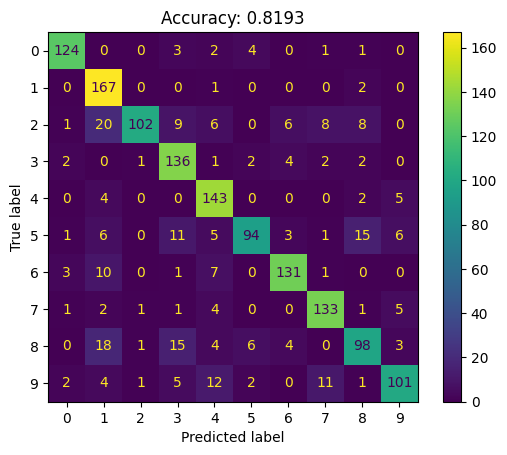

In [477]:
# train test split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=0.7, random_state=42, stratify=labels)

eta = 0.05
d = train_images.shape[1]
C = 10
np.random.seed(42)
W_init = np.random.randn(d, C)
W = softmax_regression(train_images.T, train_labels, C, W_init, eta)
print(f'weights: {W[-1]}')

# predict
y_pred = pred(W[-1], test_images.T)
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
plt.title(f'Accuracy: {accuracy_score(test_labels, y_pred):.4f}')


Softmax regression with PCA:

weights: [[ 2.33370655e+02 -1.50685974e+02 -7.94917176e+01  1.45971367e+01
  -4.52583068e+01  3.95059823e+01  2.68435961e+01 -1.90014604e+01
   7.21419874e+01 -8.75412876e+01]
 [ 1.27985920e+02  5.45809444e+01  2.04669923e+02  1.40252780e+02
  -2.18409654e+02  1.17759800e+02 -4.87831880e+01 -2.39071337e+02
   9.20594547e+01 -2.38951226e+02]
 [ 2.42881832e+01 -6.05380365e+01 -3.40980544e+01  1.22927198e+02
  -2.44768463e+01  8.05697126e+01 -1.64385151e+02  7.03724859e+01
   4.74235266e+01 -6.43014535e+01]
 [ 2.57322785e+01 -3.40602908e+01 -1.77369096e+02  1.02906699e+02
  -1.08404409e+02  1.85268616e+02 -1.75709068e+02  7.62048447e+01
   8.92770029e+01  1.30523560e+01]
 [-2.15464554e+02 -5.16740285e+00  7.09326962e+01 -3.33699699e+00
   1.08255929e+02 -5.50774549e+01  9.39754509e+01 -2.57905300e+02
   2.24670253e+02  3.65891577e+01]
 [ 1.39400040e+01  1.02243600e+02  1.46294469e+02 -2.11837990e+01
  -6.34004287e+01 -1.34219950e+02 -1.80061586e+02 -1.25636096e+01
   1.00934587e+02  5.001

Text(0.5, 1.0, 'Accuracy: 0.8187')

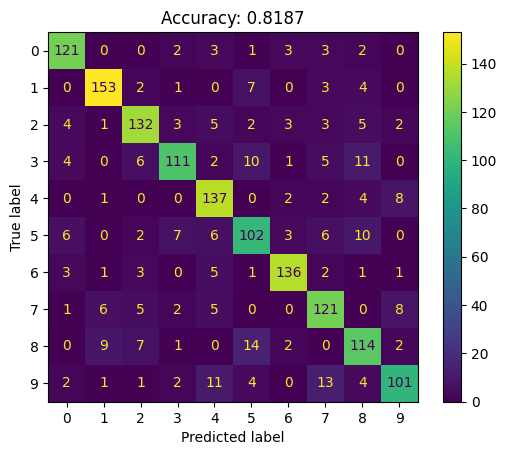

In [478]:
# a. pca -> train test split
pca = PCA(n_components=100)
transformed_images = pca.fit_transform(images)

### train test split
train_transformed, test_transformed, y_train, y_test = train_test_split(
    transformed_images, labels, train_size=0.7, random_state=42, stratify=labels)

eta = 0.05
d = train_transformed.shape[1]
C = 10
np.random.seed(42)
W_init = np.random.randn(d, C)
W = softmax_regression(train_transformed.T, y_train, C, W_init, eta)
print(f'weights: {W[-1]}')

# predict
y_pred = pred(W[-1], test_transformed.T)
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
plt.title(f'Accuracy: {accuracy_score(test_labels, y_pred):.4f}')

weights: [[ 3.03682774e+02 -1.36021735e+02 -5.09697148e+01  1.44056279e+01
  -6.37595651e+01  2.89250121e+01 -2.18799547e+01 -5.82836215e+01
   3.59336295e+01 -4.75518411e+01]
 [ 4.37287459e+01  6.16856225e+01  2.01941936e+02  1.97609598e+02
  -2.05176232e+02  1.01034588e+02 -2.75687798e+01 -2.07698276e+02
   4.80105052e+01 -2.21474290e+02]
 [ 1.33007142e+02  3.50522698e+00  1.03137000e+01 -1.86276615e+02
   6.78828277e+00 -5.63529072e+01  7.00635998e+01  1.45887121e+01
  -3.02599103e+01  3.24043331e+01]
 [ 9.18743275e+01 -6.36587692e+01 -3.13629138e+02  1.65342616e+02
  -7.43714134e+01  2.22118040e+02 -2.41056953e+02  1.80593231e+02
   4.17257230e+01 -1.20387309e+01]
 [-1.90120803e+02 -4.21722092e+01  9.99786322e+01  1.22164084e+01
   4.75025856e+01 -8.14956646e+01  1.94749873e+01 -1.45100763e+02
   2.39319821e+02  3.78687838e+01]
 [ 2.39494910e+00 -7.76035166e+01 -1.31484574e+02 -4.85416104e+01
  -3.39595284e+01  1.61346457e+02  2.21215509e+02 -6.88975663e+01
  -9.74619941e+00 -1.272

Text(0.5, 1.0, 'Accuracy: 0.8320')

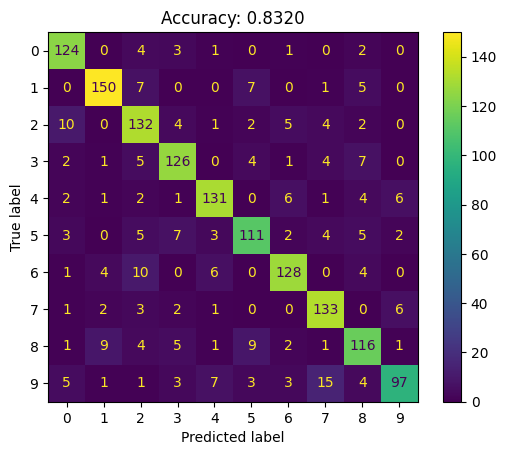

In [479]:
# b. train test split -> pca

train_images, test_images, y_train, y_test = train_test_split(
    images, labels, train_size=0.7, random_state=42, stratify=labels)

pca = PCA(n_components=100)
train_transformed = pca.fit_transform(train_images)
test_transformed = pca.transform(test_images)

eta = 0.05
d = train_transformed.shape[1]
C = 10
np.random.seed(42)
W_init = np.random.randn(d, C)
W = softmax_regression(train_transformed.T, y_train, C, W_init, eta)
print(f'weights: {W[-1]}')

# predict
y_pred = pred(W[-1], test_transformed.T)
ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
plt.title(f'Accuracy: {accuracy_score(test_labels, y_pred):.4f}')

- Cách thực hiện chia train test -> pca cho kết quả tốt hơn so với 2 cách tiếp cận còn lại.